## A pixelizer toy for intersecting planes with spheres in 3D


### setup
requires:
* numpy
* ipympl
* matplotlib
* jupyter

```
pip install numpy ipympl matplotlib jupyterlab
```


In [2]:
import numpy as np 
%matplotlib ipympl
import matplotlib.pyplot as plt 

In [59]:
# build some spherical cells. these will be cell **EDGES**
r = np.linspace(0,1,64)
theta = np.linspace(0, np.pi, 64)
phi = np.linspace(0, np.pi * 2., 64)

# cell centers 
r_c = (r[1:] + r[:-1] ) / 2.
theta_c = (theta[1:] + theta[:-1] ) / 2.
phi_c = (phi[1:] + phi[:-1]) / 2.

def sphere_to_cart(r, theta, phi):
    z_c = r * np.cos(theta)
    x_c = r * np.sin(theta) * np.cos(phi)
    y_c = r * np.sin(theta) * np.sin(phi)
    return x_c, y_c, z_c
    
# define some data at the cell centers
def get_xyz(r_c, theta_c, phi_c):
    R, Th, Ph = np.meshgrid(r_c, theta_c, phi_c, indexing='ij')
    return sphere_to_cart(R, Th, Ph)

x_c, y_c, z_c = get_xyz(r_c, theta_c, phi_c)

In [90]:
# build a cartesian plane that passes through the origin

# select your normal vector
normal = np.array([0.5, 0.000001, 0.2])  
normal_unit = normal / np.linalg.norm(normal)

# calculate or set some vectors in the plane as basis vectors: choose one arbitary, construct 3rd 
# remember, eq of plane: 𝑎𝑥+𝑏𝑦+𝑐𝑧+𝑑=0. , normal = (a, b, c), d = 0 when origin is in plane
if np.all(normal_unit == np.array([0.,0., 1])): 
    # the plane **is** the x-y plane 
    north = np.array([0., 1., 0])
    east = np.array([1., 0., 0.])
elif np.all(normal_unit == np.array([0.,1.,0.])): 
    # the plane **is** the x-z plane 
    north = np.array([0., 0., 1.])
    east = np.array([1., 0., 0.])
elif np.all(normal_unit == np.array([1.,0.,0.])): 
    # the plane **is** the y-z plane 
    north = np.array([0., 0., 1.])
    east = np.array([0., 1., 0.])
elif normal[2] == 0:
    # z is in the plane
    z_o = 1.0
    x_o = 1.0
    # calculate y so that it is the plane
    y_o = (-normal[0] * x_o) / normal[1]
    north = np.array([x_o, y_o, z_o])
    east = np.cross(north, normal)
else:
    # arbitarily pick a point in plane to be north
    x_o = 1.0 # arbitary
    y_o = 1.0 # arbitrary
    # calculate z so that it is the plane
    z_o = (-normal[0] * x_o - normal[1] * y_o) / normal[2]
    north = np.array([x_o, y_o, z_o])
    east = np.cross(north, normal)

north = north / np.linalg.norm(north)
east = east / np.linalg.norm(east)

In [91]:
# the in-plane coordinates to build an image buffer from 
in_plane_x = np.linspace(-1.5, 1.5, 50)
in_plane_y = np.linspace(-1.5, 1.5, 50)
xpts, ypts = np.meshgrid(in_plane_x, in_plane_y, indexing='ij')

In [92]:
# actual x, y, z locations of each point in the plane 
x_global = xpts * east[0] + ypts * north[0]
y_global = xpts * east[1] + ypts * north[1]
z_global = xpts * east[2] + ypts * north[2]

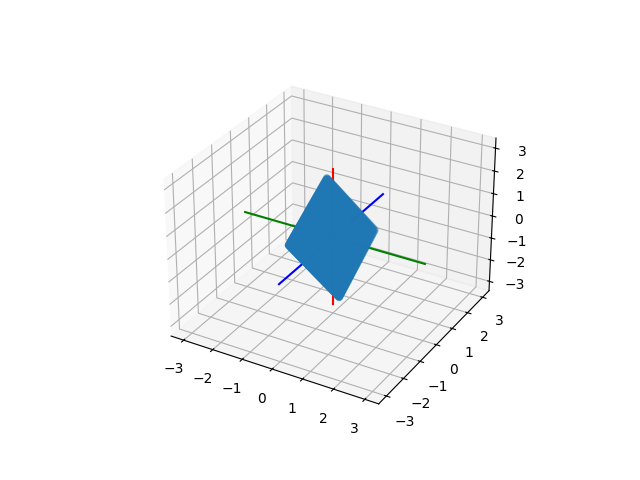

In [93]:
# plot the plane in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_global, y_global, z_global)
ax.plot([0,0], [0, 0], [0, -3],'r')
ax.plot([0,-3], [0, 0], [0, 0],'g')
ax.plot([0,0], [0, -3], [0, 0],'b')
ax.plot([0,0], [0, 0], [0, 3],'r')
ax.plot([0,3], [0, 0], [0, 0],'g')
ax.plot([0,0], [0, 3], [0, 0],'b')

In [94]:
# pixelize! 

# first get spherical coords of points in plane
r_plane = np.sqrt(x_global**2 + y_global**2 + z_global**2)
theta_plane = np.arccos(z_global / (r_plane+1e-8)) # 0 to pi angle
phi_plane = np.arctan2(y_global, x_global) # 0 to 2pi angle
# arctan2 returns -pi to pi, shift it and handle periodicity 
phi_plane = phi_plane + np.pi
phi_plane[phi_plane > 2*np.pi] = phi_plane[phi_plane > 2*np.pi] - 2 * np.pi

In [95]:
# find the cells containing each 
r_id = np.digitize(r_plane, r) -1
r_id[r_id>r_c.size-1] = r_c.size-1 # will mask later
theta_id = np.digitize(theta_plane, theta) -1
phi_id = np.digitize(phi_plane, phi) -1

In [96]:
# fill a buffer with samples from cells 
buff = y_c[r_id, theta_id, phi_id]

# mask values beyond radius
bad = np.logical_or(r_plane>r.max(), r_plane<0)
buff[bad] = np.nan

in-plane plot of the image buffer

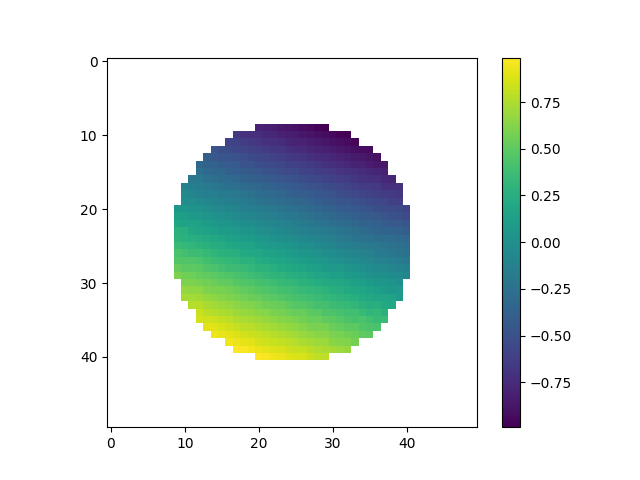

In [97]:
fig = plt.figure()
ax = fig.add_subplot()
b = ax.imshow(buff)
plt.colorbar(b)

In [98]:
buff.shape

(50, 50)

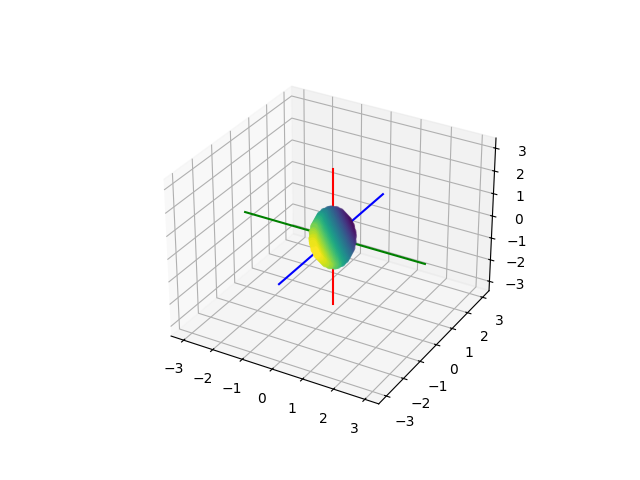

In [99]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_global, y_global, z_global, c=buff)
ax.plot([0,0], [0, 0], [0, -3],'r')
ax.plot([0,-3], [0, 0], [0, 0],'g')
ax.plot([0,0], [0, -3], [0, 0],'b')
ax.plot([0,0], [0, 0], [0, 3],'r')
ax.plot([0,3], [0, 0], [0, 0],'g')
ax.plot([0,0], [0, 3], [0, 0],'b')

## encapsulate in functions

In [81]:
def calculate_plane_vectors(normal):

    # build a cartesian plane that passes through the origin
    normal_unit = normal / np.linalg.norm(normal)
    
    # calculate or set some vectors in the plane as basis vectors: choose one arbitary, construct 3rd 
    # remember, eq of plane: 𝑎𝑥+𝑏𝑦+𝑐𝑧+𝑑=0. , normal = (a, b, c), d = 0 when origin is in plane
    if np.all(normal_unit == np.array([0.,0., 1])): 
        # the plane **is** the x-y plane 
        north = np.array([0., 1., 0])
        east = np.array([1., 0., 0.])
    elif np.all(normal_unit == np.array([0.,1.,0.])): 
        # the plane **is** the x-z plane 
        north = np.array([0., 0., 1.])
        east = np.array([1., 0., 0.])
    elif np.all(normal_unit == np.array([1.,0.,0.])): 
        # the plane **is** the y-z plane 
        north = np.array([0., 0., 1.])
        east = np.array([0., 1., 0.])
    elif normal[2] == 0:
        # z is in the plane
        z_o = 1.0
        x_o = 1.0
        # calculate y so that it is the plane
        y_o = (-normal[0] * x_o) / normal[1]
        north = np.array([x_o, y_o, z_o])
        east = np.cross(north, normal)
    else:
        # arbitarily pick a point in plane to be north
        x_o = 1.0 # arbitary
        y_o = 1.0 # arbitrary
        # calculate z so that it is the plane
        z_o = (-normal[0] * x_o - normal[1] * y_o) / normal[2]
        north = np.array([x_o, y_o, z_o])
        east = np.cross(north, normal)
    
    north = north / np.linalg.norm(north)
    east = east / np.linalg.norm(east)
    return north, east

def plane_coordinates(north, east, in_plane_x_range=None, in_plane_y_range=None):

    if in_plane_x_range is None:
        in_plane_x_range = (-1.5, 1.5, 50)
    if in_plane_y_range is None:
        in_plane_y_range = (-1.5, 1.5, 50)
        
    # the in-plane coordinates to build an image buffer from 
    in_plane_x = np.linspace(in_plane_x_range[0], in_plane_x_range[1], in_plane_x_range[2]) 
    in_plane_y = np.linspace(in_plane_y_range[0], in_plane_y_range[1], in_plane_y_range[2])
    
    xpts, ypts = np.meshgrid(in_plane_x, in_plane_y, indexing='ij')
    # actual x, y, z locations of each point in the plane 
    x_global = xpts * east[0] + ypts * north[0]
    y_global = xpts * east[1] + ypts * north[1]
    z_global = xpts * east[2] + ypts * north[2]

    return xpts, ypts, x_global, y_global, z_global


def find_plane_dataset_index(x_global, y_global, z_global, r, theta, phi):
    # *_global arrays: the positions of the image plane in cartesian
    # r, theta, phi: the dataset spherical coordinates 
    
    # first get spherical coords of points in plane
    r_plane = np.sqrt(x_global**2 + y_global**2 + z_global**2)
    theta_plane = np.arccos(z_global / (r_plane+1e-8)) # 0 to pi angle
    phi_plane = np.arctan2(y_global, x_global) # 0 to 2pi angle
    # arctan2 returns -pi to pi, shift it and handle periodicity 
    phi_plane = phi_plane + np.pi
    phi_plane[phi_plane > 2*np.pi] = phi_plane[phi_plane > 2*np.pi] - 2 * np.pi


    # find the cells containing each 
    r_c = (r[1:] + r[:-1] ) / 2.
    theta_c = (theta[1:] + theta[:-1] ) / 2.
    phi_c = (phi[1:] + phi[:-1]) / 2.

    r_id = np.digitize(r_plane, r) -1
    r_id[r_id>r_c.size-1] = r_c.size-1 # will mask later
    theta_id = np.digitize(theta_plane, theta) -1
    theta_id[theta_id>theta_c.size-1] = theta_c.size-1 
    phi_id = np.digitize(phi_plane, phi) -1
    phi_id[phi_id>phi_c.size-1] = phi_c.size-1 

    bad_mask = np.logical_or(r_plane>r.max(), r_plane<0)
    return r_id, theta_id, phi_id, bad_mask

def fill_image_buffer(field, r_id, theta_id, phi_id, bad_mask):
    # fill a buffer with samples from cells 
    buff = field[r_id, theta_id, phi_id]
    
    # apply the mask    
    buff[bad_mask] = np.nan
    return buff 


def get_image(field, r, theta, phi, normal, in_plane_x_range=None, in_plane_y_range=None):
    north, east = calculate_plane_vectors(normal)
    xpts, ypts, x_global, y_global, z_global = plane_coordinates(north, east, in_plane_x_range, in_plane_y_range)
    r_id, theta_id, phi_id, bad_mask = find_plane_dataset_index(x_global, y_global, z_global, r, theta, phi)
    im_buff = fill_image_buffer(field, r_id, theta_id, phi_id, bad_mask)
    return im_buff, x_global, y_global, z_global, xpts, ypts

normal = np.array([0.5, 0.000001, 0.2])

available_fields = {
    'x_c': x_c, 
    'y_c': y_c,
    'z_c': z_c,
    'r': np.sqrt(x_c**2+y_c**2+z_c**2)
}
im_buff, x_global, y_global, z_global, xpts, ypts = get_image(available_fields['y_c'], r, theta, phi, normal)

In [82]:
from ipywidgets import *

fig = plt.figure(figsize=(10,6))
ax_3d = fig.add_subplot(1,2,1,projection='3d')
ax_2d = fig.add_subplot(1,2,2)

def build_figs(n_x = 1.0, n_y = 1.0, n_z = 1.0, field='y_c'):

    
    normal = np.array([n_x+1e-10, n_y+1e-10, n_z+1e-10], dtype='float')
    field_vals = available_fields[field]
    clims = [field_vals.min(), field_vals.max()]
    im_buff, x_global, y_global, z_global, xpts, ypts = get_image(field_vals, r, theta, phi, normal)
    
    ax_3d.clear()
    scpl = ax_3d.scatter(x_global, y_global, z_global, c=im_buff)
    scpl.set_clim(clims)
    ax_3d.plot([0,0], [0, 0], [0, -1],'r')
    ax_3d.plot([0,-1], [0, 0], [0, 0],'g')
    ax_3d.plot([0,0], [0, -1], [0, 0],'b')
    ax_3d.plot([0,0], [0, 0], [0, 1],'r')
    ax_3d.plot([0,1], [0, 0], [0, 0],'g')
    ax_3d.plot([0,0], [0, 1], [0, 0],'b')
    ax_3d.set_xlim([-1.5, 1.5])
    ax_3d.set_ylim([-1.5, 1.5])
    ax_3d.set_zlim([-1.5, 1.5])
    ax_3d.set_xlabel('x')
    ax_3d.set_ylabel('y')
    ax_3d.set_zlabel('z')

    ax_2d.clear()
    im = ax_2d.imshow(im_buff, origin='lower', extent=(xpts.min(), xpts.max(), ypts.min(), ypts.max()))
    im.set_clim(clims)
    plt.show()



selected_field=Dropdown(
        description="Select :", value="x_c", options=list(available_fields.keys())
    )

    
interact(build_figs, n_x = (-1,1,0.1), n_y = (-1,1,0.1), n_z = (-1., 1., 0.1), field = selected_field);


interactive(children=(FloatSlider(value=1.0, description='n_x', max=1.0, min=-1.0), FloatSlider(value=1.0, des…

## cross-sections

define 2 points , note that this will always find the x-section along the minor arc

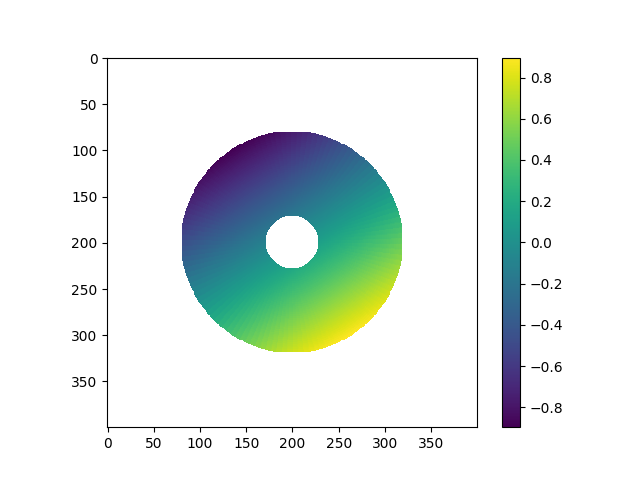

In [101]:
def get_cross_section(field, r, theta, phi, pt1, pt2, in_plane_x_range=None, in_plane_y_range=None):

    
    # define cartesian vectors from origin to each point
    # and find a normal to a plane containing those two vectors
    pt1_xyz = sphere_to_cart(*pt1)
    pt1_xyz = pt1_xyz / np.linalg.norm(pt1_xyz)
    pt2_xyz = sphere_to_cart(*pt2)
    pt2_xyz = pt2_xyz / np.linalg.norm(pt2_xyz)
    normal = np.cross(pt1_xyz, pt2_xyz)
    normal_sign = np.sign(normal) # used to test whether points are between the two vectors
    ang_dist = np.arccos(np.dot(pt1_xyz, pt2_xyz))

    north, east = calculate_plane_vectors(normal)
    xpts, ypts, x_global, y_global, z_global = plane_coordinates(north, east, in_plane_x_range, in_plane_y_range)
    r_id, theta_id, phi_id, bad_mask = find_plane_dataset_index(x_global, y_global, z_global, r, theta, phi)

    # for each point, get angular distance in order mask 
    r_vals = r_c[r_id]
    theta_vals = theta[theta_id]
    phi_vals = phi[phi_id]
    
    # get angular distance between each point on image plane and the first vector
    # hmm, not working... 
    # 
    # mask if bigger than the distance between the two original vectors
    # ang_dist_vals = np.arccos(np.sin(pt1[2])*np.sin(phi_vals) + 
    #                           np.cos(pt1[2])*np.cos(phi_vals)*np.cos(pt1[1]-theta_vals))
    # ang_dist_vals = np.arccos(np.sin(pt1[1])*np.sin(theta_vals) + 
                              # np.cos(pt1[1])*np.cos(theta_vals)*np.cos(pt1[2]-phi_vals))
    
    # bad_mask = np.logical_or(bad_mask, ang_dist_vals>ang_dist)

    # also mask based on bounding r vals of the points
    bad_mask = np.logical_or(bad_mask, r_vals<pt1[0])
    bad_mask = np.logical_or(bad_mask, r_vals>pt2[0])

    
    # also need to mask if anti-clockwise form the start otherwise you get both 
    # sides 
    
    im_buff = fill_image_buffer(field, r_id, theta_id, phi_id, bad_mask)
    return im_buff, x_global, y_global, z_global, xpts, ypts


# left/right bounding box points
pt1 = (0.2, 0., .1) # (r, theta, phi)
pt2 = (0.9, .8 , .9) # (r, theta, phi)

im_buff, x_global, y_global, z_global, xpts, ypts = get_cross_section(available_fields['z_c'], 
                                                                      r, theta, phi, pt1, pt2,
                                                                     in_plane_x_range=(-1.5, 1.5, 400),
                                                                     in_plane_y_range=(-1.5, 1.5, 400),)
f = plt.figure()
ax = plt.imshow(im_buff)
# ax.set_clim([0, 1])
plt.colorbar()

In [69]:
ang_dist

2.119305985778189

In [111]:
north_pole = np.array([0., 0., 1.])
dtheta = np.arccos(np.dot(normal_unit, north_pole))
dphi = np.arccos(np.dot(normal_unit, [1., 0., 0.]))
dtheta, dphi


(1.1902899496832213, 0.380506377116675)

In [ ]:
#xpts, ypts = np.meshgrid(in_plane_x, in_plane_y, indexing='ij')

# the in-plane angular coordinates 
theta_prime = np.atan2(xpts, ypts)
r_prime = np.sqrt(xpts**2 + ypts**2)
phi_prime = np.zeros(xpts.shape)